___

# WELCOME!

___

This data originally came from Crowdflower's Data for Everyone library.

As the original source says,

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The data we're providing on Kaggle is a slightly reformatted version of the original source. It includes both a CSV file and SQLite database. The code that does these transformations is available on GitHub

For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Exploratory Data Analysis

### Import Libraries, Load and Discover the Data

In [1]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import plotly.express as px
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud 

### Some Useful User Defined Functions

In [2]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop related columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
        
###############################################################################

# To view summary information about the column

def first_look(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [ ]:
# df = pd.read_csv("../input/Tweets.csv")

In [38]:
df = pd.read_csv("Tweets.csv")

In [39]:
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.349,NaN,0.000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.684,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [40]:
df.tail(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14637,569587242672398336,neutral,1.000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.000,Customer Service Issue,0.666,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.677,NaN,0.000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [41]:
df.sample(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
3715,568174139531513856,positive,0.677,NaN,NaN,United,NaN,DCconnick,NaN,0,@united Will have to try standby in Denver tonight or will have to Cancelled Flight father son trip till next year. Thx for trying.,NaN,2015-02-18 14:24:05 -0800,NaN,NaN
12691,570060687164067840,negative,0.655,Cancelled Flight,0.333,American,NaN,shelia_talia,NaN,0,"@AmericanAir ""sorry you were disappointed"" #outoftouchwithreality #people have kids and jobs",NaN,2015-02-23 19:20:33 -0800,NaN,NaN
8207,568606685230555136,negative,0.772,Can't Tell,0.731,Delta,negative,cvsherman,Can't Tell,0,@JetBlue time to reevaluate my nyc carrier.,NaN,2015-02-19 19:02:52 -0800,"Austin, TX",Central Time (US & Canada)


In [42]:
print("There is", df.shape[0], "observation and", df.shape[1], "columns in the dataset")

There is 14640 observation and 15 columns in the dataset


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [44]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,14640.000,14640.000,10522.000,14640.000
mean,569218351767382528.000,0.900,0.638,0.083
std,779111158481836.750,0.163,0.330,0.746
min,567588278875213824.000,0.335,0.000,0.000
25%,568559178101439488.000,0.692,0.361,0.000
50%,569477857923110912.000,1.000,0.671,0.000
75%,569890473289000960.000,1.000,1.000,0.000
max,570310600460525568.000,1.000,1.000,44.000


In [45]:
df.describe(include=object)

,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,9178,14640,40,14640,32,14640,1019,14640,9907,9820
unique,3,10,6,3,7701,13,14427,832,14247,3081,85
top,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2910,3822,32,63,12,6,164,5,157,3744


In [46]:
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [47]:
# to find how many unique values numeric features have
for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} has {df[col].nunique()} unique value")

tweet_id has 14485 unique value
airline_sentiment_confidence has 1023 unique value
negativereason_confidence has 1410 unique value
retweet_count has 18 unique value


In [48]:
# to find how many unique values object features have
for col in df.select_dtypes(exclude=[np.number]).columns:
  print(f"{col} has {df[col].nunique()} unique value")

airline_sentiment has 3 unique value
negativereason has 10 unique value
airline has 6 unique value
airline_sentiment_gold has 3 unique value
name has 7701 unique value
negativereason_gold has 13 unique value
text has 14427 unique value
tweet_coord has 832 unique value
tweet_created has 14247 unique value
tweet_location has 3081 unique value
user_timezone has 85 unique value


In [50]:
print("There are", df.duplicated(subset=None, keep='first').sum(), "duplicated observations in the dataset.")
df.drop_duplicates(keep='first', inplace=True)
print("Duplicates were dropped!")

There are 0 duplicated observations in the dataset.
Duplicates were dropped!


In [51]:
df.isnull().sum().sort_values(ascending=False)

negativereason_gold             14572
airline_sentiment_gold          14564
tweet_coord                     13589
negativereason                   5445
user_timezone                    4814
tweet_location                   4723
negativereason_confidence        4101
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
airline                             0
name                                0
retweet_count                       0
text                                0
tweet_created                       0
dtype: int64

In [52]:
df.isnull().melt(value_name="missing")

,variable,missing
0,tweet_id,False
1,tweet_id,False
2,tweet_id,False
3,tweet_id,False
4,tweet_id,False
...,...,...
219055,user_timezone,True
219056,user_timezone,True
219057,user_timezone,True
219058,user_timezone,False


<Figure size 288x432 with 0 Axes>

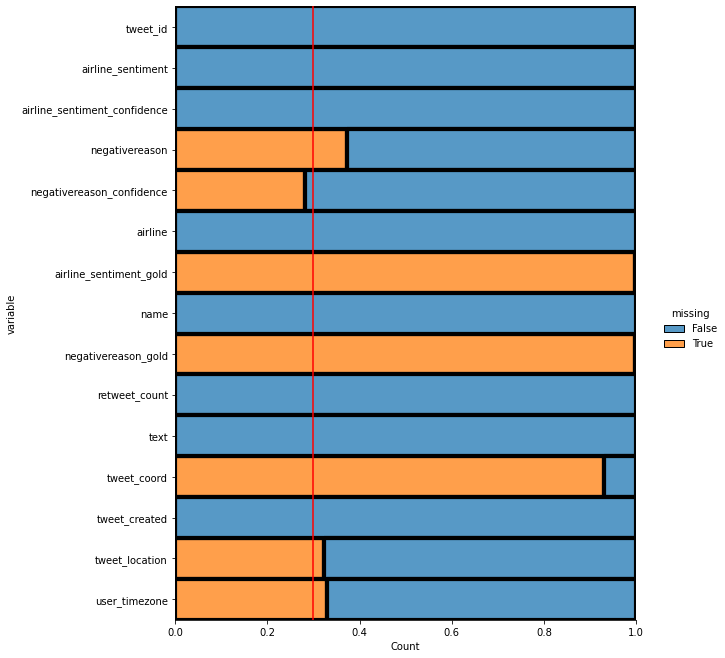

In [53]:
plt.figure(figsize=(4,6))
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25
)
plt.axvline(0.3,color="r");

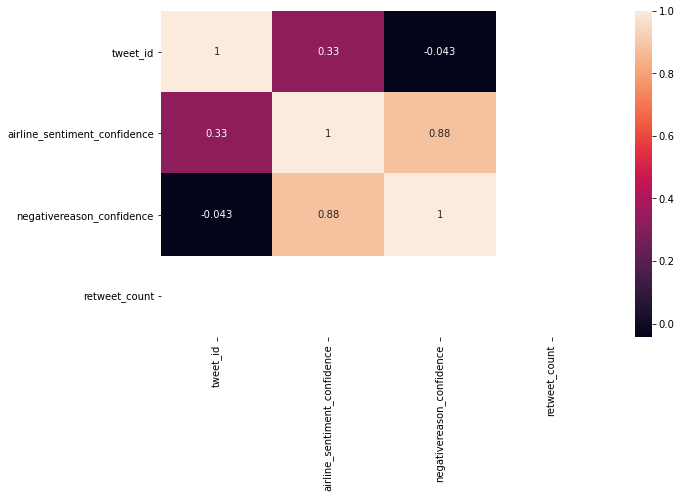

In [25]:
sns.heatmap(df.corr(), annot=True);

In [20]:
df1 = df[['airline_sentiment','text']]
df1

# NLP de biz "text" kısmıyla ve "label" kısmıyla ilgileniyoruz!!

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
...,...,...
14635,positive,@AmericanAir thank you we got on a different flight to Chicago.
14636,negative,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc
14637,neutral,@AmericanAir Please bring American Airlines to #BlackBerry10
14638,negative,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"


In [108]:
import pandas as pd
import numpy as np

In [21]:
df = df.iloc[:8, :]
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.349,NaN,0.000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.684,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.000,Bad Flight,0.703,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.000,Can't Tell,1.000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.000,Can't Tell,0.684,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.674,NaN,0.000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.634,NaN,NaN,Virgin America,pilot,0,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)


In [76]:
df2 = df.copy()

In [77]:
df2["text"] = df2["text"].apply(cleaning)

In [78]:
df2

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,virginamerica dhepburn said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica plus added commercial experience...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,virginamerica today must mean need take anothe...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,virginamerica really aggressive blast obnoxiou...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica really big bad thing,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,virginamerica seriously would pay flight seat ...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,virginamerica yes nearly every time fly vx ear...,NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,virginamerica really missed prime opportunity ...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)


## CountVectorization

In [79]:
X = df2["text"]
y = df2["airline_sentiment"]

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y, random_state = 42)

# y'ler imbalans data ise stratify yapıyoruz.

# yukarda datadan sadece 8 satır aldığımız için test_size ı 0.5 gibi büyük bir değer olarak belirledik.
# normal çözümlerde biz yine test_size a 0.1 veya 0.2 gibi değerler vereceğiz

In [115]:
X_train

6    virginamerica yes nearly every time fly vx ear...
0                          virginamerica dhepburn said
2    virginamerica today must mean need take anothe...
4                   virginamerica really big bad thing
Name: text, dtype: object

In [116]:
X_test

3    virginamerica really aggressive blast obnoxiou...
5    virginamerica seriously would pay flight seat ...
1    virginamerica plus added commercial experience...
7    virginamerica really missed prime opportunity ...
Name: text, dtype: object

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

In [83]:
vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

# fit deyince train setindeki unique olan bütün tokenleri buluyor, tespit ediyor. 
# transform deyince de onları sayıyor yani hangi kelimeden kaçar tane var tespit ediyor..

In [85]:
vectorizer.get_feature_names()

['another',
 'away',
 'bad',
 'big',
 'dhepburn',
 'ear',
 'every',
 'fly',
 'go',
 'mean',
 'must',
 'nearly',
 'need',
 'really',
 'said',
 'take',
 'thing',
 'time',
 'today',
 'trip',
 'virginamerica',
 'vx',
 'worm',
 'yes']

In [111]:
X_train_count

<4x24 sparse matrix of type '<class 'numpy.int64'>'
	with 27 stored elements in Compressed Sparse Row format>

In [84]:
X_train_count.toarray()

# tüm dokümanları array şekline getiriyoruz. 

array([[0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0]], dtype=int64)

In [113]:
pd.set_option('display.max_columns', 50)

In [114]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())

# data olarak X_train_count.toarray() o al, column olarak vectorizer içindeki tüm featureların isimlerini al. 

,another,away,bad,big,dhepburn,ear,every,fly,go,mean,must,nearly,need,really,said,take,thing,time,today,trip,virginamerica,vx,worm,yes
0,0,1,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,1,0,0,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [88]:
X_train[6]

'virginamerica yes nearly every time fly vx ear worm go away'

In [55]:
vectorizer.vocabulary_

# her kelimeden kaçar tane geçtiğini görebiliyoruz.

{'virginamerica': 20,
 'yes': 23,
 'nearly': 11,
 'every': 6,
 'time': 17,
 'fly': 7,
 'vx': 21,
 'ear': 5,
 'worm': 22,
 'go': 8,
 'away': 1,
 'dhepburn': 4,
 'said': 14,
 'today': 18,
 'must': 10,
 'mean': 9,
 'need': 12,
 'take': 15,
 'another': 0,
 'trip': 19,
 'really': 13,
 'big': 3,
 'bad': 2,
 'thing': 16}

## TF-IDF

sklearn TD-IDF
https://towardsdatascience.com/how-sklearns-tf-idf-is-different-from-the-standard-tf-idf-275fa582e73d

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
tf_idf_vectorizer = TfidfVectorizer()
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

# fit burada tüm tokenleri sayıyor. sonra da teker teker öncelikle TF fonksiyonunu uyguluyor. 
#  sonra IDF bulmak için bu kelimeler tüm dokümanlarda geçmiş mi geçmemiş mi onları sayıyor. 
# transform deyince de TF-IDF katsayısını hesaplayıp buluyor.

In [93]:
tf_idf_vectorizer.get_feature_names()

['another',
 'away',
 'bad',
 'big',
 'dhepburn',
 'ear',
 'every',
 'fly',
 'go',
 'mean',
 'must',
 'nearly',
 'need',
 'really',
 'said',
 'take',
 'thing',
 'time',
 'today',
 'trip',
 'virginamerica',
 'vx',
 'worm',
 'yes']

In [94]:
X_train_tf_idf.toarray()

array([[0.        , 0.31200802, 0.        , 0.        , 0.        ,
        0.31200802, 0.31200802, 0.31200802, 0.31200802, 0.        ,
        0.        , 0.31200802, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.31200802, 0.        , 0.        ,
        0.16281873, 0.31200802, 0.31200802, 0.31200802],
       [0.        , 0.        , 0.        , 0.        , 0.66338461,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.66338461,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.34618161, 0.        , 0.        , 0.        ],
       [0.37082034, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.37082034,
        0.37082034, 0.        , 0.37082034, 0.        , 0.        ,
        0.37082034, 0.        , 0.        , 0.37082034, 0.37082034,
        0.19350944, 0.        , 0.        , 0.        ],
       [0.   

In [95]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names())

,another,away,bad,big,dhepburn,ear,every,fly,go,mean,must,nearly,need,really,said,take,thing,time,today,trip,virginamerica,vx,worm,yes
0,0.00000,0.312008,0.000000,0.000000,0.000000,0.312008,0.312008,0.312008,0.312008,0.00000,0.00000,0.312008,0.00000,0.000000,0.000000,0.00000,0.000000,0.312008,0.00000,0.00000,0.162819,0.312008,0.312008,0.312008
1,0.00000,0.000000,0.000000,0.000000,0.663385,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.663385,0.00000,0.000000,0.000000,0.00000,0.00000,0.346182,0.000000,0.000000,0.000000
2,0.37082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.37082,0.37082,0.000000,0.37082,0.000000,0.000000,0.37082,0.000000,0.000000,0.37082,0.37082,0.193509,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.483803,0.483803,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.483803,0.000000,0.00000,0.483803,0.000000,0.00000,0.00000,0.252468,0.000000,0.000000,0.000000


In [96]:
X_train[6]

'virginamerica yes nearly every time fly vx ear worm go away'

In [99]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names()).loc[1].sort_values(ascending=False)

# virginamerica tüm dokümanlarda geçtiği için doğal olarak onun ağırlığını azaltmış. en hafifi o olmuş.

dhepburn         0.663385
said             0.663385
virginamerica    0.346182
another          0.000000
really           0.000000
worm             0.000000
vx               0.000000
trip             0.000000
today            0.000000
time             0.000000
thing            0.000000
take             0.000000
need             0.000000
away             0.000000
nearly           0.000000
must             0.000000
mean             0.000000
go               0.000000
fly              0.000000
every            0.000000
ear              0.000000
big              0.000000
bad              0.000000
yes              0.000000
Name: 1, dtype: float64

In [100]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names()).loc[0].sort_values(ascending=False)

# loc[0] da da virginamerica nın en düşük ağırlığa sahip olduğunu görüyoruz. 

yes              0.312008
worm             0.312008
vx               0.312008
ear              0.312008
every            0.312008
fly              0.312008
go               0.312008
nearly           0.312008
away             0.312008
time             0.312008
virginamerica    0.162819
take             0.000000
trip             0.000000
today            0.000000
thing            0.000000
another          0.000000
said             0.000000
really           0.000000
must             0.000000
mean             0.000000
dhepburn         0.000000
big              0.000000
bad              0.000000
need             0.000000
Name: 0, dtype: float64